In [3]:
from PPIN_fcm import *
from parzen_window import plot_class_result
from scipy.stats import chi2_contingency

total = pd.read_csv('./data/all4cons.csv')
data_ids = pd.read_csv('./data/newData.csv', index_col = 0).iloc[:, :6]
total = total.merge(data_ids, how = 'left', left_on = 'id', right_on = 'id')
total

,id,0`,8`,40`,120`,condition,protein,protein.names,gene.symbol,amino.acid,position,sequence
0,13-S149,-1.205462,0.918781,1.054825,-0.768145,EGF_lo,A0A075B6E4,Transcription cofactor vestigial-like protein 4,VGLL4,S,149.0,ALTKNSLDASRPAGLSPTLTPGERQQNRPSV
1,66-S107,-1.712921,0.424201,0.811027,0.477693,EGF_lo,A0A087WUT6,Eukaryotic translation initiation factor 5B,EIF5B,S,107.0,TSKDKKKKGQKGKKQSFDDNDSEELEDKDSK
2,166-S118,-1.645030,0.791698,0.815898,0.037434,EGF_lo,A0A087WZH7,Myristoylated alanine-rich C-kinase substrate,MARCKS,S,118.0,VEKEAPAEGEAAEPGSPTAAEGEAASAASST
3,175-S101,-1.717248,0.502763,0.432885,0.781600,EGF_lo,A0A087WZH7,Myristoylated alanine-rich C-kinase substrate,MARCKS,S,101.0,EKGEPAAAAAPEAGASPVEKEAPAEGEAAEP
4,252-S987,-1.690181,0.847806,0.607889,0.234486,EGF_lo,F8W7U3,WASH complex subunit FAM21C;Putative WASH comp...,FAM21C,S,987.0,SVPRGPIAQWADGAISPNGHRPQLRAASGED
...,...,...,...,...,...,...,...,...,...,...,...,...
1156,10013-T433,-1.141437,1.585920,-0.426200,-0.018283,FGF_hi,Q9H8Y8,Golgi reassembly-stacking protein 2,GORASP2,T,433.0,TAKAPTTVEDRVGDSTPVSEKPVSAAVDANA
1157,10122-T1003,1.624833,-0.711123,0.010473,-0.924183,FGF_hi,Q9UQ35,Serine/arginine repetitive matrix protein 2,SRRM2,T,1003.0,SHSGSISPYPKVKAQTPPGPSLSGSKSPCPQ
1158,10144-T866,0.589775,0.395072,0.734590,-1.719436,FGF_hi,Q9UQ35,Serine/arginine repetitive matrix protein 2,SRRM2,T,866.0,RQGSITSPQANEQSVTPQRRSCFESSPDPEL
1159,10299-Y204,-1.470548,1.352540,0.034904,0.083104,FGF_hi,P27361,Mitogen-activated protein kinase 3;Mitogen-act...,MAPK3,Y,204.0,RIADPEHDHTGFLTEYVATRWYRAPEIMLNS


### 1. Calculate the optimal fuzzification parameter

In [4]:
m = calc_fuzzifier(4, 1161)

In [5]:
gene_set = set(total['gene.symbol'])
edges, degree_map, N, edges_string = request_edges(gene_set)
avg_local_cc, local_cc, n = calc_avg_cc(edges, degree_map, N)
avg_local_cc

0.5508804326986146

### 2. Run FCM and calculate clustering coefficients from 6 to 20 

In [4]:
local_cc_mus = run_fcm_cc(total, 6, 21, m)

7.172786235809326s elapsed for 6 centres: average adjusted clustering coefficient per cluster: 0.08197089777886069

8.187743186950684s elapsed for 7 centres: average adjusted clustering coefficient per cluster: 0.07416034544489301

8.103239297866821s elapsed for 8 centres: average adjusted clustering coefficient per cluster: 0.07900561128166075

8.378334045410156s elapsed for 9 centres: average adjusted clustering coefficient per cluster: 0.10340580796721148

8.771464824676514s elapsed for 10 centres: average adjusted clustering coefficient per cluster: 0.08564147295041605

13.024450063705444s elapsed for 11 centres: average adjusted clustering coefficient per cluster: 0.07415362646275897

9.33739686012268s elapsed for 12 centres: average adjusted clustering coefficient per cluster: 0.08665993450520304

9.624197244644165s elapsed for 13 centres: average adjusted clustering coefficient per cluster: 0.06325076212132529

10.239389896392822s elapsed for 14 centres: average adjusted cluster

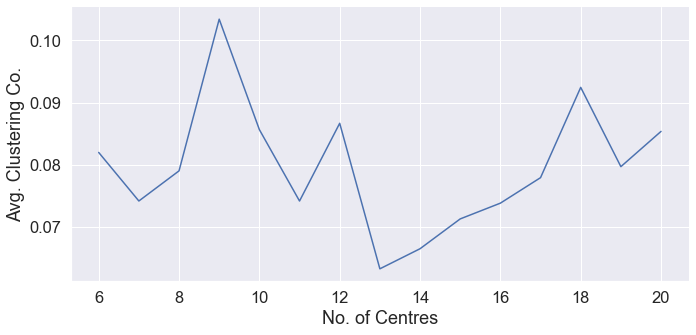

In [5]:
%matplotlib inline
sns.set(font_scale = 1.5)

plot_data = pd.DataFrame(np.hstack((np.atleast_2d(np.arange(6, 21)).T, 
                                    np.atleast_2d(np.array(local_cc_mus)).T)),
                         columns = ['ncentres', 'avg.cc'])

g = sns.relplot(x="ncentres", y="avg.cc", kind="line", data=plot_data)
g.fig.set_size_inches(12,5)
g.set(xlabel = 'No. of Centres', ylabel = 'Avg. Clustering Co.')

### 3. Use the optimal fuzzier and number of centres to run clustering

/opt/anaconda3/envs/test_env/lib/python3.7/site-packages/seaborn/axisgrid.py:913: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, **kwargs)


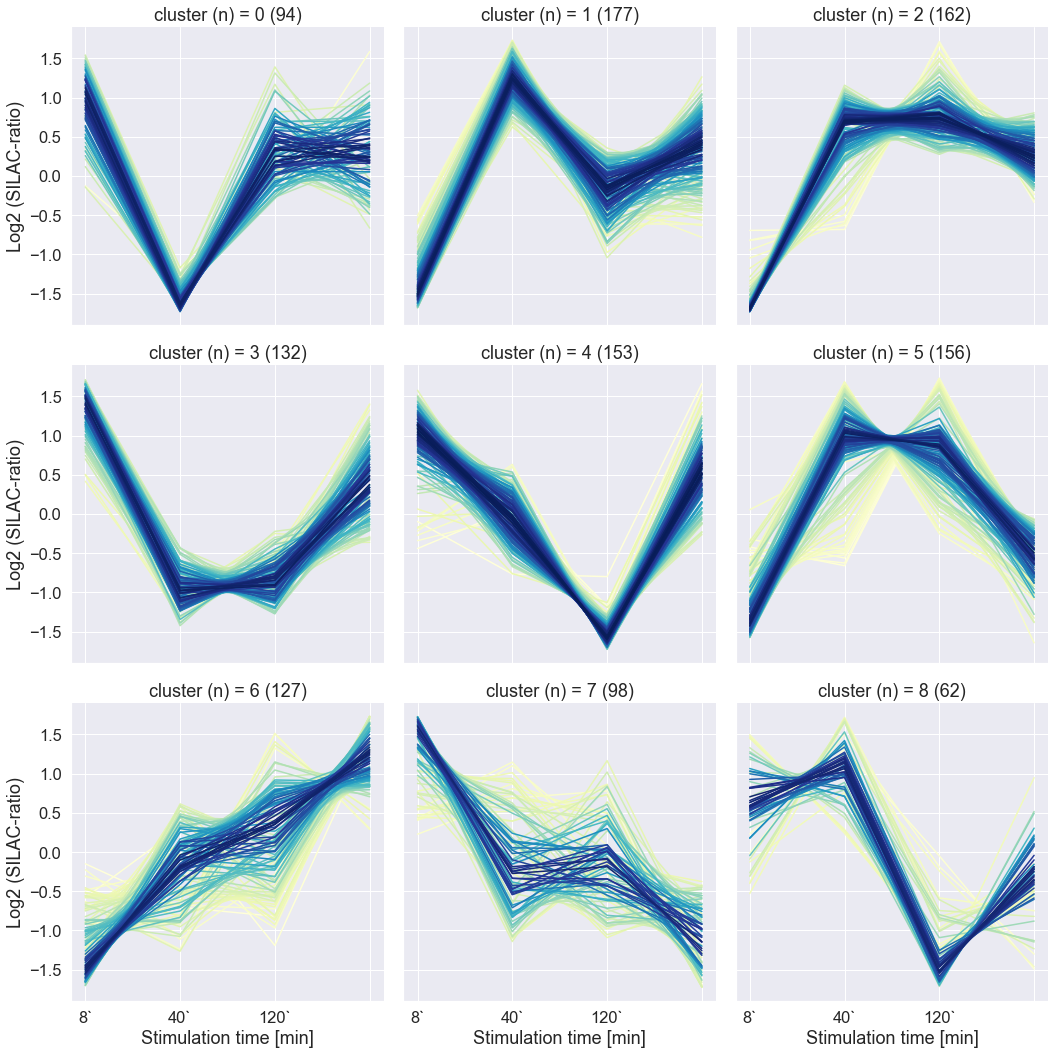

In [6]:
cl_data = total.iloc[:, :6]
cl, membership, cntr, u, fpc = fuzzy_c_means(cl_data.iloc[:, 1:5].values, 9, m)
cl_data['cl'] = cl
cl_data['membership'] = membership
order = cl_data.columns[1:5]
sm = plot_time_series(cl_data, ['id', 'cl', 'membership', 'condition'], 'cl', order, col_wrap = 3)

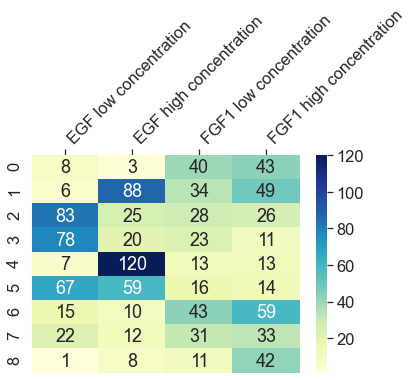

In [7]:
conditions = ['EGF_lo', 'EGF_hi', 'FGF_lo', 'FGF_hi']
titles = ['EGF low concentration', 'EGF high concentration', 'FGF1 low concentration', 'FGF1 high concentration']
label_dict = dict(zip(range(9), range(9)))
plot_class_result(cl_data, 'cl', conditions, titles, label_dict)

### 4. Save the results for network generation

In [8]:
total['cl'] = cl_data['cl']
total['membership'] = cl_data['membership']
total.to_csv('./data/clustering_results.csv', index = None)

### 5. Test if multiple phosphosites of genes are the major cause of different temporal dynamics

In [9]:
total['amino.acid.position'] = total['id'].apply(lambda x: x.split('-')[1])
total['phospho.id'] = total[['gene.symbol', 'amino.acid.position']].agg('-'.join, axis=1)
phosph_id_table = total[['phospho.id', 'cl', 'gene.symbol']].drop_duplicates()
phosph_id_table['site_cl_count'] = phosph_id_table.groupby(['phospho.id'])['cl'].transform('nunique')
phosph_id_table['gene_cl_count'] = phosph_id_table.groupby(['gene.symbol'])['cl'].transform('nunique')
phosph_id_table['gene_site_count'] = phosph_id_table.groupby(['gene.symbol'])['phospho.id'].transform('nunique')
n_single_single = phosph_id_table[(phosph_id_table['gene_cl_count'] == 1)
                                  & (phosph_id_table['gene_site_count'] == 1
                                    )][['gene.symbol']].drop_duplicates().shape[0]
n_single_multi = phosph_id_table[(phosph_id_table['gene_cl_count'] > 1)
                                  & (phosph_id_table['gene_site_count'] == 1
                                    )][['gene.symbol']].drop_duplicates().shape[0]
n_multi_single = phosph_id_table[(phosph_id_table['gene_cl_count'] == 1)
                                  & (phosph_id_table['gene_site_count'] > 1
                                    )][['gene.symbol']].drop_duplicates().shape[0]
n_multi_multi = phosph_id_table[(phosph_id_table['gene_cl_count'] > 1)
                                  & (phosph_id_table['gene_site_count'] > 1
                                    )][['gene.symbol']].drop_duplicates().shape[0]
cont_table = pd.DataFrame([[n_single_single, n_single_multi],
                          [n_multi_single, n_multi_multi]], 
                          columns = ['No. of single-cluster genes', 'No. of multi-cluster genes'],
                         index = ['No. of single-site genes', 'No. of multi-site genes'])
print('Chi-squared test p-value: {0}'.format(chi2_contingency(cont_table.values)[1]))
cont_table

Chi-squared test p-value: 8.097591798745725e-24


,No. of single-cluster genes,No. of multi-cluster genes
No. of single-site genes,235,105
No. of multi-site genes,13,91
